In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [126]:
# Load the data
data = pd.read_csv('data.csv')
predictions_template = pd.read_csv('predictions.csv')

In [127]:
data.head()

,PITCH_TYPE,PITCH_NAME,PLAYER_NAME,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_PK,GAME_YEAR,GAME_DATE,...,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE,POST_AWAY_SCORE,POST_HOME_SCORE,POST_BAT_SCORE,POST_FLD_SCORE,DELTA_HOME_WIN_EXP,DELTA_RUN_EXP
0,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.038
1,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.049
2,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.052
3,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.113
4,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.077


In [128]:
predictions_template.head()

,BATTER_ID,PLAYER_NAME,GAME_YEAR,PITCH_TYPE_FB,PITCH_TYPE_BB,PITCH_TYPE_OS
0,444482,"Peralta, David",2024,0.542,0.285,0.173
1,453568,"Blackmon, Charlie",2024,0.609,0.244,0.147
2,456781,"Solano, Donovan",2024,0.571,0.330,0.099
3,457705,"McCutchen, Andrew",2024,0.552,0.330,0.118
4,457759,"Turner, Justin",2024,0.598,0.303,0.099


In [129]:
# Data Preprocessing
def preprocess_data(df):
    # Map pitch types to categories
    fastballs = ['FF', 'FC', 'SI', 'FA']
    breaking_balls = ['CU', 'SL', 'ST', 'KC', 'CS', 'SV']
    off_speed = ['CH', 'FS', 'FO', 'KN', 'EP', 'SC']
    
    df['PITCH_CATEGORY'] = df['PITCH_TYPE'].map(lambda x: 'FB' if x in fastballs else ('BB' if x in breaking_balls else ('OS' if x in off_speed else 'Other')))
    
    # Create features
    df['COUNT'] = df['BALLS'].astype(str) + '-' + df['STRIKES'].astype(str)
    df['RUNNERS'] = (df['ON_1B'].notna()).astype(int) + (df['ON_2B'].notna()).astype(int) + (df['ON_3B'].notna()).astype(int)
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_columns = ['BAT_SIDE', 'THROW_SIDE', 'INNING_TOPBOT', 'IF_FIELDING_ALIGNMENT', 'OF_FIELDING_ALIGNMENT', 'COUNT']
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df


In [130]:
# Preprocess the data
processed_data = preprocess_data(data)

In [131]:
# Aggregate data by batter
def aggregate_by_batter(df):
    agg_data = df.groupby('BATTER_ID').agg({
        'PITCH_CATEGORY': lambda x: x.value_counts(normalize=True).to_dict(),
        'BAT_SIDE': 'first',
        'INNING': 'mean',
        'OUTS_WHEN_UP': 'mean',
        'BALLS': 'mean',
        'STRIKES': 'mean',
        'RUNNERS': 'mean',
        'IF_FIELDING_ALIGNMENT': lambda x: x.mode().iloc[0],
        'OF_FIELDING_ALIGNMENT': lambda x: x.mode().iloc[0],
        'PLATE_X': 'mean',
        'PLATE_Z': 'mean',
        'LAUNCH_SPEED': 'mean',
        'LAUNCH_ANGLE': 'mean'
    }).reset_index()
    for category in ['FB', 'BB', 'OS']:
        agg_data[f'{category}_PERCENTAGE'] = agg_data['PITCH_CATEGORY'].apply(lambda x: x.get(category, 0))
    
    agg_data = agg_data.drop('PITCH_CATEGORY', axis=1)
    
    return agg_data


In [132]:
aggregated_data = aggregate_by_batter(processed_data)

In [133]:
# Split the data
X = aggregated_data.drop(['BATTER_ID', 'FB_PERCENTAGE', 'BB_PERCENTAGE', 'OS_PERCENTAGE'], axis=1)
y = aggregated_data[['FB_PERCENTAGE', 'BB_PERCENTAGE', 'OS_PERCENTAGE']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [134]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [135]:
# Calculate R-squared score for each pitch type
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')

print("\nModel Accuracy (R-squared score):")
print(f"Fastballs: {r2_scores[0]:.4f}")
print(f"Breaking Balls: {r2_scores[1]:.4f}")
print(f"Off-speed: {r2_scores[2]:.4f}")


Model Accuracy (R-squared score):
Fastballs: 0.3013
Breaking Balls: 0.4818
Off-speed: 0.6399


In [136]:
# Calculate overall R-squared score
overall_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
print(f"Overall: {overall_r2:.4f}")

Overall: 0.4743


In [137]:
# Evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("\nMean Squared Error for each pitch category:")
print(f"Fastballs: {mse[0]:.4f}")
print(f"Breaking Balls: {mse[1]:.4f}")
print(f"Off-speed: {mse[2]:.4f}")


Mean Squared Error for each pitch category:
Fastballs: 0.0010
Breaking Balls: 0.0007
Off-speed: 0.0006


In [138]:
# Calculate overall R-squared score
overall_mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
print(f"Overall: {overall_mse:.4f}")

Overall: 0.0008


In [139]:
# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
print("\nTop 10 most important features:")
print(feature_importance.head(10))



Top 10 most important features:
                 feature  importance
0                PLATE_X    0.372852
1                PLATE_Z    0.196867
2           LAUNCH_SPEED    0.097429
3                  BALLS    0.067013
4           OUTS_WHEN_UP    0.062402
5                STRIKES    0.061712
6           LAUNCH_ANGLE    0.049859
7                RUNNERS    0.041397
8                 INNING    0.040927
9  IF_FIELDING_ALIGNMENT    0.007039


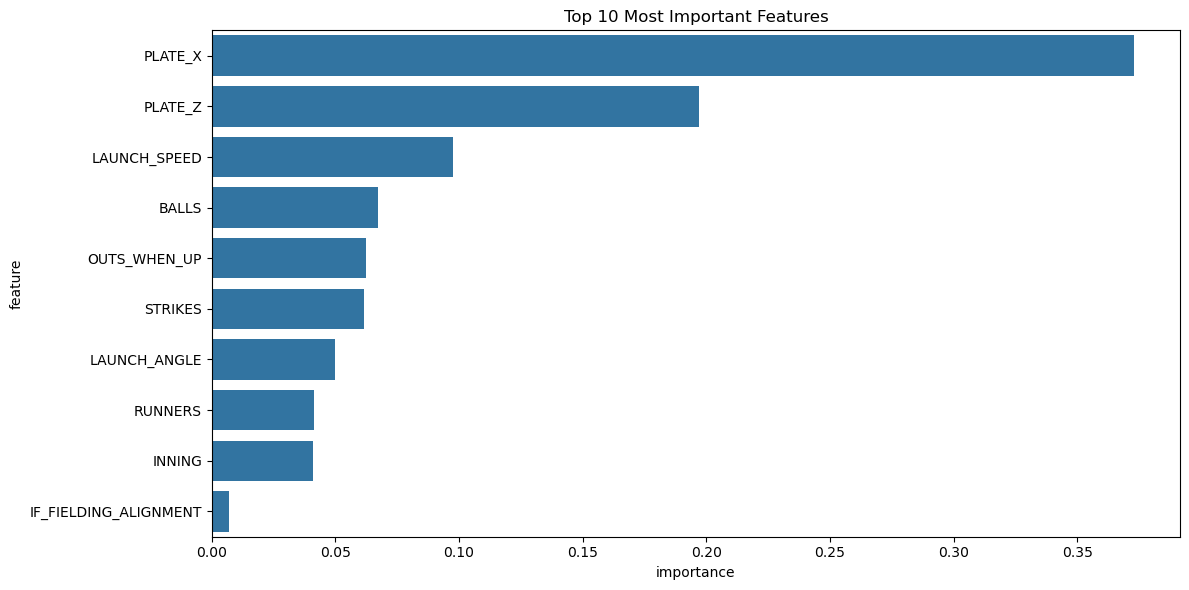

In [140]:
# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()


In [141]:
# Prepare prediction data
pred_data = predictions_template.merge(aggregated_data, on='BATTER_ID', how='left')
X_pred = pred_data[X.columns]  # Use only the columns that were used for training

# Handle missing data
X_pred = X_pred.fillna(X_pred.mean())

# Make predictions
predictions = model.predict(X_pred)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)

# Normalize predictions to ensure they sum to 1
predictions_normalized = predictions / predictions.sum(axis=1)[:, np.newaxis]


In [142]:
# Create submission file
submission = pd.DataFrame({
    'BATTER_ID': pred_data['BATTER_ID'],
    'PLAYER_NAME': pred_data['PLAYER_NAME'],
    'GAME_YEAR': pred_data['GAME_YEAR'],
    'PITCH_TYPE_FB': predictions_normalized[:, 0],
    'PITCH_TYPE_BB': predictions_normalized[:, 1],
    'PITCH_TYPE_OS': predictions_normalized[:, 2]
})


In [143]:
# Round the predictions to 3 decimal places
submission[['PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']] = submission[['PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']].round(3)

# Adjust rounding to ensure sum is exactly 1.000
pitch_types = ['PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']
for idx, row in submission.iterrows():
    values = row[pitch_types]
    if abs(values.sum() - 1.000) > 1e-10:  # Using a small threshold to account for floating point precision
        diff = 1.000 - values.sum()
        max_col = values.idxmax()
        submission.at[idx, max_col] = round(values[max_col] + diff, 3)



In [144]:
# Save predictions
submission.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'


In [145]:
# Display the first few rows of the predictions
df=pd.read_csv('predictions.csv')
df.head()

,BATTER_ID,PLAYER_NAME,GAME_YEAR,PITCH_TYPE_FB,PITCH_TYPE_BB,PITCH_TYPE_OS
0,444482,"Peralta, David",2024,0.542,0.285,0.173
1,453568,"Blackmon, Charlie",2024,0.609,0.244,0.147
2,456781,"Solano, Donovan",2024,0.571,0.330,0.099
3,457705,"McCutchen, Andrew",2024,0.552,0.330,0.118
4,457759,"Turner, Justin",2024,0.598,0.303,0.099
